In [1]:
import os
import pandas as pd
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import datetime
from scipy.interpolate import interp1d
import seaborn as sns

from utils import windpower_simulation_merra2

In [2]:
from dask.diagnostics import ProgressBar
ProgressBar().register()

In [3]:
usa_path = "C:/Users/KatharinaG/Documents/USA"

In [4]:
col_refuel7 = sns.color_palette(["#c72321","#861719","#f0c320","#af8f19","#6e9b9e","#0d8085","#19484c"])
col_refuel3 = sns.color_palette(["#c72321", "#0d8085", "#efc220"])
col_refuel5 = sns.color_palette(["#c62220", "#fbd7a8", "#7a6952", "#0d8085", "#f0c220"])
col_refuel10 = sns.color_palette(["#c72321","#861719","#fbd7a9","#ba9f7c","#7a6952","#6e9b9e","#0d8085","#19484c","#f0c320","#af8f19"])


In [5]:
rea_path = "C:/Users/KatharinaG/Data/merra/USA"

chk = {
    "time" : 38
}
data = xr.open_mfdataset(rea_path+"/*.nc",chunks=chk)

load locations of wind power plants

In [6]:
windturbines = pd.read_csv(usa_path+"/windturbines_usa.csv",delimiter=';') 

### Fill in missing wind park data

In [7]:
# 0.1% of years are missing, so set them mean of commissioning years
y = windturbines.p_year.fillna(windturbines.p_year.mean())

In [8]:
# capacities
cap = windturbines.t_cap.fillna(1700)

In [9]:
# hub heights
hh = windturbines.t_hh.fillna(80)

make commissioning dates - only years given so use middle of year

In [10]:
t = [np.datetime64(str(int(year))+"-06-01T00:00:00") for year in y]

In [11]:
# join data making a multiindex with time and state
time_state = tuples = tuple(zip(list(windturbines.t_state),t))
mi = pd.MultiIndex.from_tuples(time_state, names=['state', 'time'])
turbine_data = pd.DataFrame({'capacity':cap.values,
                             'height':hh.values,
                             'lon':windturbines.xlong.values,
                             'lat':windturbines.ylat.values,
                             'ind':range(len(cap))},index = mi)

In [12]:
turbine_data.head()

capacity  height         lon        lat  ind
state time                                                    
CA    1987-06-01      95.0    80.0 -118.358871  35.084488    0
      1987-06-01      95.0    80.0 -118.365677  35.078026    1
      1987-06-01      95.0    80.0 -118.352242  35.088539    2
      1987-06-01      95.0    80.0 -118.365860  35.077789    3
      1987-06-01      95.0    80.0 -118.352470  35.088196    4

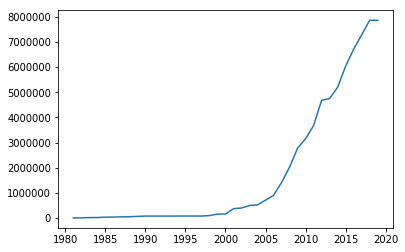

In [13]:
plt.plot(windturbines.groupby(windturbines.p_year).sum().p_cap.cumsum())

# Simulate wind power per state

In [22]:
for state in turbine_data.index.levels[0].values[-2:]:
    print(state)
    ind = turbine_data.xs(state).ind.values
    wps = windpower_simulation_merra2(data,
                                    turbine_data.height[ind].values,
                                    turbine_data.capacity[ind].values,
                                    turbine_data.lon[ind].values,
                                    turbine_data.lat[ind].values,
                                    turbine_data.iloc[ind].index.get_level_values(level=1).values)
    # save as netcdf
    wps.to_dataset(name='wp').to_netcdf(usa_path+"/results/windpower_"+state+"_MERRA2.nc")

WV


C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\dask\array\blockwise.py:210: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")


[                                        ] | 0% Completed |  3.8s

C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\scipy\interpolate\interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]


[########################################] | 100% Completed | 37min 31.8s
WY


C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\dask\array\blockwise.py:210: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")


[                                        ] | 0% Completed |  3.6s

C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\scipy\interpolate\interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]


[########################################] | 100% Completed | 37min 45.8s


# Simulate wind power per state with GWA

In [14]:
GWA_USA = xr.open_rasterio(usa_path+'/GWA/GWA_USA50m.tif')

In [15]:
# three regions are not included in the continental USA region: Alaska, Haitii and Puerto Rico
GWA_AK = xr.open_rasterio(usa_path+'/GWA/GWA_AK50m.tif')
GWA_HI = xr.open_rasterio(usa_path+'/GWA/GWA_HI50m.tif')
GWA_PR = xr.open_rasterio(usa_path+'/GWA/GWA_PR50m.tif')

In [17]:
for state in turbine_data.index.levels[0].values:
    print(state)
    ind = turbine_data.xs(state).ind.values
    # select the correct wind atlas
    if state=='AK':
        GWA = GWA_AK
    elif state=='HI':
        GWA = GWA_HI
    elif state=='PR':
        GWA = GWA_PR
    else:
        GWA = GWA_USA
    wps = windpower_simulation_merra2(data,
                                    turbine_data.height[ind].values,
                                    turbine_data.capacity[ind].values,
                                    turbine_data.lon[ind].values,
                                    turbine_data.lat[ind].values,
                                    turbine_data.iloc[ind].index.get_level_values(level=1).values,
                                    GWA)
    # save as netcdf
    wps.to_dataset(name='wp').to_netcdf(usa_path+"/results/windpower_"+state+"_MERRA2_GWA.nc")

AK


C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\xarray\backends\rasterio_.py:122: RuntimeWarning: invalid value encountered in greater
  out = riods.read(band_key, window=window)
C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\xarray\backends\rasterio_.py:122: RuntimeWarning: invalid value encountered in less
  out = riods.read(band_key, window=window)
C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\scipy\interpolate\interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]
C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\dask\array\blockwise.py:210: UserWarning: The da.atop function has moved

[                                        ] | 0% Completed |  4.2s

C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\scipy\interpolate\interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]


[########################################] | 100% Completed | 37min 47.2s
AR


C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\scipy\interpolate\interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]
C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\dask\array\blockwise.py:210: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")


[                                        ] | 0% Completed |  3.8s

C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\scipy\interpolate\interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]


[########################################] | 100% Completed | 37min  7.8s
AZ


C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\scipy\interpolate\interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]
C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\dask\array\blockwise.py:210: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")


[                                        ] | 0% Completed |  4.1s

C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\scipy\interpolate\interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]


[########################################] | 100% Completed | 37min 14.7s
CA


C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\scipy\interpolate\interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]
C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\dask\array\blockwise.py:210: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")


[                                        ] | 0% Completed |  3.8s

C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\scipy\interpolate\interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]


[########################################] | 100% Completed | 40min 59.6s
CO


C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\scipy\interpolate\interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]
C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\dask\array\blockwise.py:210: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")


[                                        ] | 0% Completed |  4.7s

C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\scipy\interpolate\interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]


[########################################] | 100% Completed | 37min 52.4s
CT


C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\scipy\interpolate\interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]
C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\dask\array\blockwise.py:210: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")


[                                        ] | 0% Completed |  3.8s

C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\scipy\interpolate\interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]


[########################################] | 100% Completed | 37min 29.5s
DE


C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\scipy\interpolate\interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]
C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\dask\array\blockwise.py:210: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")


[                                        ] | 0% Completed |  4.1s

C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\scipy\interpolate\interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]


[########################################] | 100% Completed | 37min 15.6s
FL


C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\scipy\interpolate\interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]
C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\dask\array\blockwise.py:210: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")


[                                        ] | 0% Completed |  3.9s

C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\scipy\interpolate\interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]


[########################################] | 100% Completed | 37min 12.2s
GU


C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\scipy\interpolate\interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]
C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\dask\array\blockwise.py:210: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")


[                                        ] | 0% Completed |  3.9s

C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\scipy\interpolate\interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]


[###############                         ] | 37% Completed | 16min 23.2s

C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\dask\array\numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[###############                         ] | 37% Completed | 16min 24.7s

C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in less_equal
  return func(*args2)


[########################################] | 100% Completed | 37min 17.9s
HI


C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\scipy\interpolate\interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]
C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\dask\array\blockwise.py:210: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")


[                                        ] | 0% Completed |  3.9s

C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\scipy\interpolate\interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]


[########################################] | 100% Completed | 37min  6.3s
IA


C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\scipy\interpolate\interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]
C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\dask\array\blockwise.py:210: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")


[                                        ] | 0% Completed |  3.8s

C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\scipy\interpolate\interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]


[########################################] | 100% Completed | 40min  7.1s
ID


C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\scipy\interpolate\interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]
C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\dask\array\blockwise.py:210: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")


[                                        ] | 0% Completed |  4.5s

C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\scipy\interpolate\interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]


[########################################] | 100% Completed | 37min 19.2s
IL


C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\scipy\interpolate\interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]
C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\dask\array\blockwise.py:210: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")


[                                        ] | 0% Completed |  3.8s

C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\scipy\interpolate\interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]


[########################################] | 100% Completed | 37min 35.6s
IN


C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\scipy\interpolate\interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]
C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\dask\array\blockwise.py:210: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")


[                                        ] | 0% Completed |  3.8s

C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\scipy\interpolate\interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]


[########################################] | 100% Completed | 37min  9.0s
KS


C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\scipy\interpolate\interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]
C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\dask\array\blockwise.py:210: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")


[                                        ] | 0% Completed |  4.1s

C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\scipy\interpolate\interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]


[########################################] | 100% Completed | 38min 16.5s
MA


C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\scipy\interpolate\interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]
C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\dask\array\blockwise.py:210: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")


[                                        ] | 0% Completed |  4.3s

C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\scipy\interpolate\interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]


[########################################] | 100% Completed | 37min  9.1s
MD


C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\scipy\interpolate\interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]
C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\dask\array\blockwise.py:210: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")


[                                        ] | 0% Completed |  4.0s

C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\scipy\interpolate\interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]


[########################################] | 100% Completed | 37min  0.2s
ME


C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\scipy\interpolate\interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]
C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\dask\array\blockwise.py:210: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")


[                                        ] | 0% Completed |  4.0s

C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\scipy\interpolate\interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]


[########################################] | 100% Completed | 37min 13.5s
MI


C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\scipy\interpolate\interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]
C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\dask\array\blockwise.py:210: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")


[                                        ] | 0% Completed |  4.0s

C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\scipy\interpolate\interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]


[########################################] | 100% Completed | 37min 23.7s
MN


C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\scipy\interpolate\interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]
C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\dask\array\blockwise.py:210: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")


[                                        ] | 0% Completed |  3.9s

C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\scipy\interpolate\interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]


[########################################] | 100% Completed | 38min  8.6s
MO


C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\scipy\interpolate\interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]
C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\dask\array\blockwise.py:210: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")


[                                        ] | 0% Completed |  3.8s

C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\scipy\interpolate\interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]


[########################################] | 100% Completed | 37min 13.7s
MT


C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\scipy\interpolate\interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]
C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\dask\array\blockwise.py:210: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")


[                                        ] | 0% Completed |  4.0s

C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\scipy\interpolate\interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]


[########################################] | 100% Completed | 37min 22.3s
NC


C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\scipy\interpolate\interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]
C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\dask\array\blockwise.py:210: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")


[                                        ] | 0% Completed |  3.9s

C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\scipy\interpolate\interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]


[########################################] | 100% Completed | 37min 29.7s
ND


C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\scipy\interpolate\interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]
C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\dask\array\blockwise.py:210: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")


[                                        ] | 0% Completed |  3.7s

C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\scipy\interpolate\interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]


[########################################] | 100% Completed | 37min 45.7s
NE


C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\scipy\interpolate\interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]
C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\dask\array\blockwise.py:210: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")


[                                        ] | 0% Completed |  3.7s

C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\scipy\interpolate\interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]


[########################################] | 100% Completed | 37min 37.5s
NH


C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\scipy\interpolate\interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]
C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\dask\array\blockwise.py:210: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")


[                                        ] | 0% Completed |  4.0s

C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\scipy\interpolate\interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]


[########################################] | 100% Completed | 37min 19.1s
NJ


C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\scipy\interpolate\interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]
C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\dask\array\blockwise.py:210: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")


[                                        ] | 0% Completed |  4.0s

C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\scipy\interpolate\interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]


[########################################] | 100% Completed | 37min 21.6s
NM


C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\scipy\interpolate\interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]
C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\dask\array\blockwise.py:210: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")


[                                        ] | 0% Completed |  3.9s

C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\scipy\interpolate\interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]


[########################################] | 100% Completed | 37min 32.8s
NV


C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\scipy\interpolate\interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]
C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\dask\array\blockwise.py:210: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")


[                                        ] | 0% Completed |  3.8s

C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\scipy\interpolate\interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]


[########################################] | 100% Completed | 37min 13.2s
NY


C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\scipy\interpolate\interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]
C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\dask\array\blockwise.py:210: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")


[                                        ] | 0% Completed |  4.1s

C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\scipy\interpolate\interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]


[########################################] | 100% Completed | 37min 35.3s
OH


C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\scipy\interpolate\interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]
C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\dask\array\blockwise.py:210: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")


[                                        ] | 0% Completed |  4.0s

C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\scipy\interpolate\interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]


[########################################] | 100% Completed | 37min 33.6s
OK


C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\scipy\interpolate\interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]
C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\dask\array\blockwise.py:210: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")


[                                        ] | 0% Completed |  3.8s

C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\scipy\interpolate\interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]


[########################################] | 100% Completed | 39min  0.6s
OR


C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\scipy\interpolate\interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]
C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\dask\array\blockwise.py:210: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")


[                                        ] | 0% Completed |  4.3s

C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\scipy\interpolate\interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]


[########################################] | 100% Completed | 37min 48.0s
PA


C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\scipy\interpolate\interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]
C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\dask\array\blockwise.py:210: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")


[                                        ] | 0% Completed |  3.8s

C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\scipy\interpolate\interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]


[########################################] | 100% Completed | 37min 32.9s
PR


C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\scipy\interpolate\interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]
C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\dask\array\blockwise.py:210: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")


[                                        ] | 0% Completed |  4.1s

C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\scipy\interpolate\interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]


[########################################] | 100% Completed | 37min 26.0s
RI


C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\scipy\interpolate\interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]
C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\dask\array\blockwise.py:210: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")


[                                        ] | 0% Completed |  4.2s

C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\scipy\interpolate\interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]


[########################################] | 100% Completed | 37min 31.7s
SD


C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\scipy\interpolate\interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]
C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\dask\array\blockwise.py:210: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")


[                                        ] | 0% Completed |  4.0s

C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\scipy\interpolate\interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]


[########################################] | 100% Completed | 37min 29.5s
TN


C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\scipy\interpolate\interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]
C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\dask\array\blockwise.py:210: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")


[                                        ] | 0% Completed |  4.0s

C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\scipy\interpolate\interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]


[########################################] | 100% Completed | 37min 19.7s
TX


C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\scipy\interpolate\interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]
C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\dask\array\blockwise.py:210: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")


[                                        ] | 0% Completed |  3.9s

C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\scipy\interpolate\interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]


[########################################] | 100% Completed | 42min 10.4s
UT


C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\scipy\interpolate\interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]
C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\dask\array\blockwise.py:210: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")


[                                        ] | 0% Completed |  4.5s

C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\scipy\interpolate\interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]


[########################################] | 100% Completed | 37min 52.7s
VT


C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\scipy\interpolate\interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]
C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\dask\array\blockwise.py:210: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")


[                                        ] | 0% Completed |  3.8s

C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\scipy\interpolate\interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]


[########################################] | 100% Completed | 37min 11.8s
WA


C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\scipy\interpolate\interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]
C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\dask\array\blockwise.py:210: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")


[                                        ] | 0% Completed |  3.8s

C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\scipy\interpolate\interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]


[########################################] | 100% Completed | 37min 55.4s
WI


C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\scipy\interpolate\interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]
C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\dask\array\blockwise.py:210: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")


[                                        ] | 0% Completed |  3.9s

C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\scipy\interpolate\interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]


[########################################] | 100% Completed | 37min 47.5s
WV


C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\scipy\interpolate\interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]
C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\dask\array\blockwise.py:210: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")


[                                        ] | 0% Completed |  3.8s

C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\scipy\interpolate\interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]


[########################################] | 100% Completed | 37min 43.5s
WY


C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\scipy\interpolate\interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]
C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\dask\array\blockwise.py:210: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")


[                                        ] | 0% Completed |  3.9s

C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\scipy\interpolate\interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]


[########################################] | 100% Completed | 37min 35.9s


# Sum up regions

## States

In [23]:
for STATE in turbine_data.index.levels[0].values:
    print(STATE)
    wp_loc = xr.open_dataset(usa_path+"/results/windpower_"+STATE+"_MERRA2.nc")
    wp_state = wp_loc.sum('location')
    if 'wp' in locals():
        wp = xr.concat([wp,wp_state.expand_dims(state=[STATE])],dim='state')
    else:
        wp = wp_state.expand_dims(state=[STATE])
    
# save as netcdf
wp.to_netcdf(usa_path+"/results/windpower_states_MERRA2.nc")
del(wp)

AK
AR
AZ
CA
CO
CT
DE
FL
GU
HI
IA
ID
IL
IN
KS
MA
MD
ME
MI
MN
MO
MT
NC
ND
NE
NH
NJ
NM
NV
NY
OH
OK
OR
PA
PR
RI
SD
TN
TX
UT
VT
WA
WI
WV
WY


In [18]:
for STATE in turbine_data.index.levels[0].values:
    wp_loc = xr.open_dataset(usa_path+"/results/windpower_"+STATE+"_MERRA2_GWA.nc")
    wp_state = wp_loc.sum('location')
    if 'wp' in locals():
        wp = xr.concat([wp,wp_state.expand_dims(state=[STATE])],dim='state')
    else:
        wp = wp_state.expand_dims(state=[STATE])
    
# save as netcdf
wp.to_netcdf(usa_path+"/results/windpower_states_MERRA2_GWA.nc")
del(wp)

## BPA

In [19]:
# load BPA wind parks
BPA_parks = pd.read_csv(usa_path+"/BPA_windparks.csv")
# add wind park names to turbine data
turbine_data['name'] = windturbines.p_name.values
for state in BPA_parks.state.unique():
    # load data of BPA states
    wp_loc = xr.open_dataset(usa_path+"/results/windpower_"+state+"_MERRA2.nc")
    # get indices of BPA parks
    ind = [park in BPA_parks.name[BPA_parks.state==state].values for park in turbine_data.xs(state).name.values]
    # select BPA parks and sum up
    wp_state = wp_loc.isel(location=ind).sum('location')
    if 'wp' in locals():
        wp = xr.concat([wp,wp_state.expand_dims(state=[state])],dim='state')
    else:
        wp = wp_state.expand_dims(state=[state])
# sum over states
wpBPA = wp.sum('state')
# save as netcdf
wpBPA.to_netcdf(usa_path+"/results/windpower_BPA_MERRA2.nc")
del(wp)

In [20]:
# load BPA wind parks
BPA_parks = pd.read_csv(usa_path+"/BPA_windparks.csv")
# add wind park names to turbine data
turbine_data['name'] = windturbines.p_name.values
for state in BPA_parks.state.unique():
    # load data of BPA states
    wp_loc = xr.open_dataset(usa_path+"/results/windpower_"+state+"_MERRA2_GWA.nc")
    # get indices of BPA parks
    ind = [park in BPA_parks.name[BPA_parks.state==state].values for park in turbine_data.xs(state).name.values]
    # select BPA parks and sum up
    wp_state = wp_loc.isel(location=ind).sum('location')
    if 'wp' in locals():
        wp = xr.concat([wp,wp_state.expand_dims(state=[state])],dim='state')
    else:
        wp = wp_state.expand_dims(state=[state])
# sum over states
wpBPA = wp.sum('state')
# save as netcdf
wpBPA.to_netcdf(usa_path+"/results/windpower_BPA_MERRA2_GWA.nc")

## New England
New England is a part of the USA consisting of the states Connecticut, New Hampshire, Maine, Massachusetts, Rhode Island and Vermont (CT, NH, ME, MA, RI, VT)

In [25]:
NE_states = ['CT','NH','ME','MA','RI','VT']
# without GWA
wp_state = xr.open_dataset(usa_path+"/results/windpower_states_MERRA2.nc")
wpNE = wp_state.sel(state=NE_states).sum('state')
wpNE.to_netcdf(usa_path+"/results/windpower_NewEngland_MERRA2.nc")
# with GWA
wp_state = xr.open_dataset(usa_path+"/results/windpower_states_MERRA2_GWA.nc")
wpNE = wp_state.sel(state=NE_states).sum('state')
wpNE.to_netcdf(usa_path+"/results/windpower_NewEngland_MERRA2_GWA.nc")

InvalidIndexError: Reindexing only valid with uniquely valued Index objects

## USA

In [26]:
# without GWA
wp_state = xr.open_dataset(usa_path+"/results/windpower_states_MERRA2.nc")
wpUSA = wp_state.sum('state')
wpUSA.to_netcdf(usa_path+"/results/windpower_USA_MERRA2.nc")
# with GWA
wp_state = xr.open_dataset(usa_path+"/results/windpower_states_MERRA2_GWA.nc")
wpUSA = wp_state.sum('state')
wpUSA.to_netcdf(usa_path+"/results/windpower_USA_MERRA2_GWA.nc")